In [4]:
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append('/tmp/local_scratch/v_neelesh_bisht/3d-cnn/')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from config import CnnConfig
from dataset import TrainTestDataset
from models import CNN3D
from utils import CommonUtils, Device
from train import Train
from validate import Validate
from inference import Inference

In [5]:
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


config = CnnConfig()

# get device for processing
device_obj = Device()
device_obj.set_device(config.gpu_id)
device = device_obj.get_device()
print(f"Using device: {device}")

Using device: cuda:3


In [6]:
train_dataset = TrainTestDataset()

# Create datasets
validation_dataset = train_dataset.validation_dataset
train_loader = train_dataset.train_loader
validation_loader = train_dataset.validation_loader
test_loader = train_dataset.test_loader

for inputs, labels in train_loader:
    print(inputs.shape)
    break

CT scans with normal lung tissue: 254
CT scans with abnormal lung tissue: 254


Number of samples in train, validation and test are 406 , 51 and 51.
torch.Size([4, 1, 64, 128, 128])


<class 'torch.Tensor'>
Dimensions of the CT scan are: (1, 64, 128, 128)


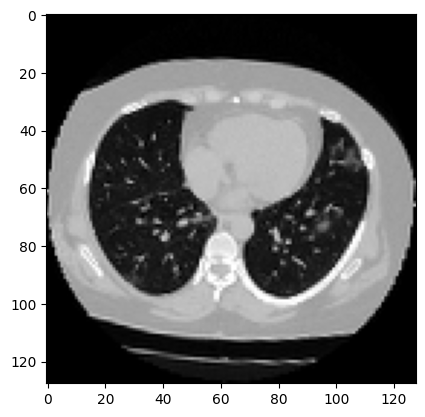

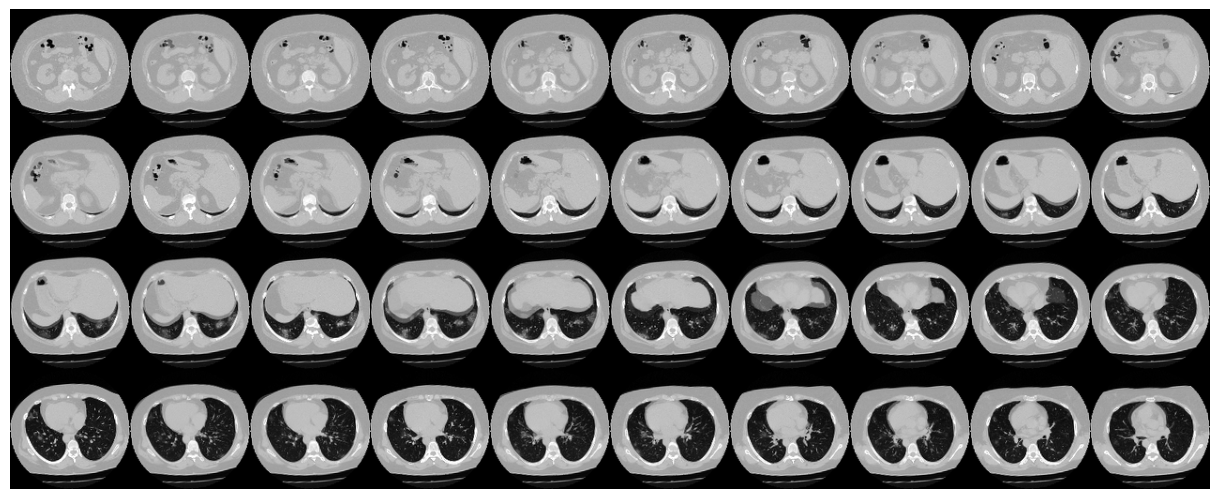

In [7]:
# Get a single batch from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Convert the images to numpy arrays
print(type(images))
# images = images[0]
images = images.numpy()
image = images[0]

print('Dimensions of the CT scan are:', image.shape)

# Visualize a slice from the 3D CT scan
plt.imshow(np.squeeze(image[0, 30, :, :, ]), cmap='gray')
plt.show()

# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
image = image[0] # (64, 128, 128) (depth, width, height)
t_image = np.transpose(image, (1, 2, 0)) # (128, 128, 64) (width, height, depth)
CommonUtils.plot_slices(4, 10, 128, 128, t_image[:, : ,:40]) # (128, 128, 40) (width, height, depth)

In [8]:
# Build model
model = CNN3D().to(device)
print(model)

CNN3D(
  (conv1): Conv3DBlock(
    (conv3d): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv3DBlock(
    (conv3d): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Conv3DBlock(
    (conv3d): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Con

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss for binary classification # Change
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
best_val_loss = float('inf')
prev_val_acc = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Learning rate scheduler
def lr_schedule(epoch):
    return config.learning_rate * (config.lr_decay_rate ** (epoch // 100000))

# Main training loop
for epoch in range(config.epochs):
    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_schedule(epoch)
        
    train_loss, train_acc = Train.train(model, train_loader, optimizer, criterion, epoch , device)
    val_loss, val_acc = Validate.validate(model, validation_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), config.model_path)
    
    # After training loop, append the performance metrics to history for visualization
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Early stopping
    if epoch > 53 and val_acc < prev_val_acc: 
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    prev_val_acc = val_acc


Epoch 1/100, Train Loss: 0.6589, Train Acc: 0.6133, Val Loss: 0.6059, Val Acc: 0.6275
Epoch 2/100, Train Loss: 0.6298, Train Acc: 0.6626, Val Loss: 0.6177, Val Acc: 0.6471
Epoch 3/100, Train Loss: 0.6345, Train Acc: 0.6502, Val Loss: 0.5941, Val Acc: 0.6863
Epoch 4/100, Train Loss: 0.6429, Train Acc: 0.6404, Val Loss: 0.6519, Val Acc: 0.5882
Epoch 5/100, Train Loss: 0.6101, Train Acc: 0.6626, Val Loss: 0.6034, Val Acc: 0.6667
Epoch 6/100, Train Loss: 0.6269, Train Acc: 0.6626, Val Loss: 0.5720, Val Acc: 0.6863
Epoch 7/100, Train Loss: 0.5910, Train Acc: 0.6724, Val Loss: 0.6767, Val Acc: 0.7059
Epoch 8/100, Train Loss: 0.5698, Train Acc: 0.7020, Val Loss: 0.7717, Val Acc: 0.6078
Epoch 9/100, Train Loss: 0.5894, Train Acc: 0.7094, Val Loss: 0.6121, Val Acc: 0.6863
Epoch 10/100, Train Loss: 0.5715, Train Acc: 0.7069, Val Loss: 0.7442, Val Acc: 0.6078
Epoch 11/100, Train Loss: 0.5341, Train Acc: 0.7315, Val Loss: 0.5889, Val Acc: 0.6863
Epoch 12/100, Train Loss: 0.5646, Train Acc: 0.6995,

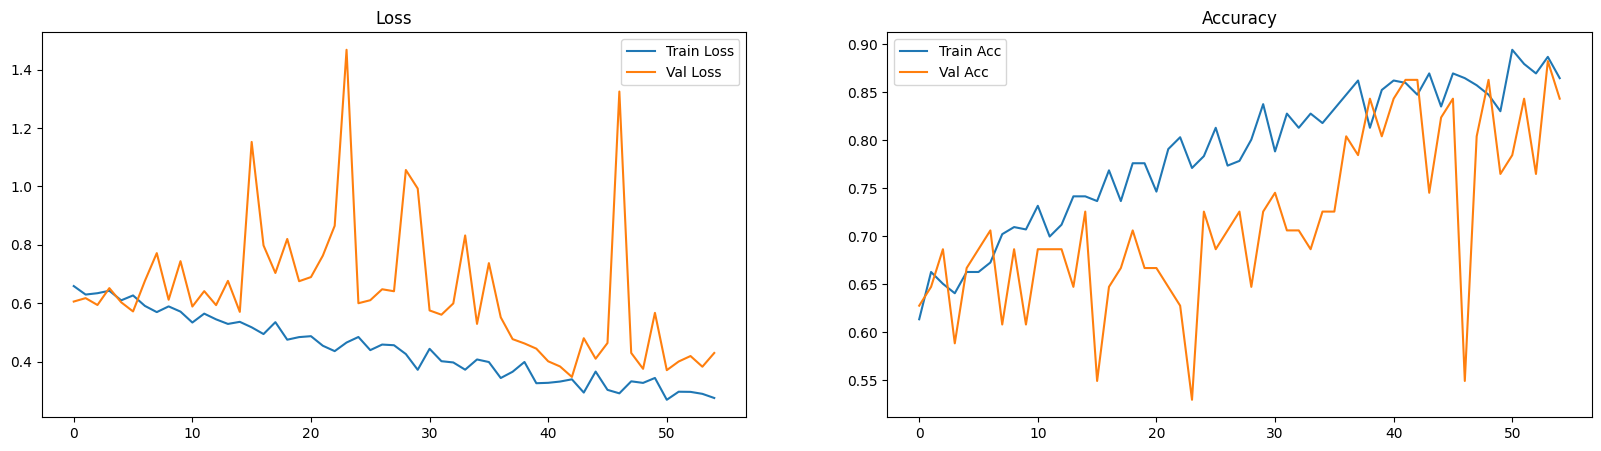

In [10]:
CommonUtils.plot_accuracy_loss_graphs(history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc'])

In [13]:
model.load_state_dict(torch.load(config.model_path))
model.eval()

# For testing
test_acc = Inference.inference(model, test_loader, device)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8431
